# Reinforcement Learning with Atari Tennis
The aim of this notebook is to experiment with Reinforcement Learning (RL) by exploring its application in mastering the classic Atari game, Tennis.

The goal is to develop and train an RL agent capable of playing Atari Tennis at a proficient level.

In [1]:
# Import necessary libraries and packages
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import random
from ale_py import ALEInterface
from ale_py.roms import Tennis
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import save_model
from tensorflow.keras.models import load_model
from datetime import datetime
from collections import deque
import time

## Loading the ROM for Atari Tennis
In this section, we will load the ROM (Read-Only Memory) for the Atari Tennis game, which we will use to train our Reinforcement Learning (RL) model. The Atari Learning Environment (ALE) provides a convenient interface to interact with Atari 2600 games, allowing us to simulate the game environment and retrieve observations and rewards.

In [2]:
# Load the ROM for Atari Tennis
ale = ALEInterface()
ale.loadROM(Tennis)

## Hyperparameters 
In this section, we define the key hyperparameters and training parameters that will guide the learning process of our RL agent. These parameters play a crucial role in determining the efficiency and effectiveness of the training.

Hyperparameters are the variables that control the learning process. Fine-tuning these parameters can significantly impact the performance of the RL agent. Below are the hyperparameters used in this project:
* `learning_rate` - The learning rate determines how much new information overrides the old information.
* `exploration_factor` - The exploration factor dictates the probability of the agent exploring new actions versus exploiting known actions.
* `exploration_factor_min` - Minimum probability of exploration.
* `exploration_decay` - Rate at which the exploration factor decreases over time.
* `discount_factor` - The discount factor represents the importance of future rewards.
* `training_episodes` - The number of episodes during which the agent will interact with the environment to learn and improve its performance.
* `testing_episodes` - The number of episodes used to evaluate the performance of the trained agent without further learning.
* `max_steps` - The maximum number of steps the agent can take in a single episode. This prevents episodes from running indefinitely and ensures consistent evaluation.

In [3]:
# Hyperparameters
hyperparameters = {
    "learning_rate": 0.1,           # Learning Rate
    "exploration_factor": 1.0,      # Exploration Factor (initial)
    "exploration_factor_min":0.1,   # Minimum Exploration Factor
    "exploration_decay":0.995,      # Exploration Decay
    "discount_factor": 0.99,        # Discount Factor
    "training_episodes": 50,        # Number of training episodes
    "testing_episodes": 1,          # Number of testing episdoes
    "max_steps": 100,               # Maximum steps per episode
    "replay_buffer_size": 10000,
    "batch_size": 32,
    "save_interval": 100
}

## Initializing the Environment
In this section, we initialize the game environment for our RL agent using the Gym library, which provides a standard API for interfacing with various environments including Atari games. Specifically, we use the 'ALE/Tennis-v5' environment, which simulates the Atari Tennis game.

In [4]:
# Initialize the environment
env = gym.make('ALE/Tennis-v5',full_action_space=True)
env.reset() 

(array([[[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],
 
        ...,
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [ 82, 126,  45],
         [ 82, 126,  45],
         [ 82, 126,  45]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [ 82, 126,  45],
         [ 82, 126,  45],
         [ 82, 126,  45]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [ 82, 126,  45],
  

## Action Space and Observation Space
By analyzing the action and observation spaces, we gain valuable insights into the complexity and structure of the Atari Tennis environment. The action space informs us about the available actions that the agent can choose from, while the observation space describes the format of the information provided to the agent about the current state of the game.

Understanding these spaces allows us to design RL algorithms and neural network architectures tailored to the specific characteristics of the environment, ultimately facilitating effective learning and decision-making.

In [5]:
actions = env.action_space.n 
height, width, channels = env.observation_space.shape

## Building the Neural Network Model

We define a function `build_model` that constructs a neural network model follows a typical architecture for deep Q-networks (DQN) used in Atari game playing agents. It is designed to process raw pixel inputs from the game environment and output Q-values for each possible action. This model will serve as the backbone for our RL agent, allowing it to learn and make decisions based on the game's observations.

Function parameters:
* `height` - Height of the input image.
* `width` - Width of the input image.
* `channels` - Number of color channels in the input image.
* `actions` - Number of possible actions in the environment.

Model Architecture:
* `Convolutional Layers` - These layers are designed to extract features from the input image. Uses ReLU activation functions.
* `Flatten ` - The output of the convolutional layers is flattened to prepare it for input to the fully connected layers.
* `Fully Connected Layers` - These layers (Dense) with ReLU activation functions aims to process the extracted features and learn representations relevant for decision-making.
* `Output Layer` - A fully connected layer with a linear activation function, producing the Q-values for each action in the environment.


In [6]:
def build_model(height, width, channels, actions):
    model = Sequential()
    model.add(Conv2D(32, (8,8), strides=(4,4), activation='relu', input_shape=(height,width,channels)))
    model.add(Conv2D(64, (4,4), strides=(2,2), activation='relu'))
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(512,activation='relu'))
    model.add(Dense(256,activation='relu'))
    model.add(Dense(actions,activation='linear'))
    return model

In [7]:
model = build_model(height, width, channels, actions)
model.summary()

d:\Projects\RL-tennis\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 51, 39, 32)     │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 18, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 22, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 22528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    11,534,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 18)             │         4,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,746,738 (44.81 MB)

 Trainable params: 11,746,738 (44.81 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
class DQNAgent:
    def __init__(self, model, actions, hyperparameters):
        self.model = model
        self.actions = actions
        self.learning_rate = hyperparameters["learning_rate"]
        self.epsilon = hyperparameters["exploration_factor"]
        self.epsilon_min = hyperparameters["exploration_factor_min"]
        self.epsilon_decay = hyperparameters["exploration_decay"]
        self.optimizer = Adam(learning_rate=self.learning_rate)
        self.model.compile(optimizer=self.optimizer, loss='mse')
        self.replay_buffer = deque(maxlen=hyperparameters["replay_buffer_size"])
        self.batch_size = hyperparameters["batch_size"]
        self.discount_factor = hyperparameters["discount_factor"]

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.actions)
        else:
            q_values = self.model.predict(state,verbose=0)
            return np.argmax(q_values[0])

    def remember(self, state, action, reward, next_state, done):
        self.replay_buffer.append((state, action, reward, next_state, done))

    def replay(self):
        if len(self.replay_buffer) < self.batch_size:
            return
        minibatch = random.sample(self.replay_buffer, self.batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.discount_factor * np.max(self.model.predict(next_state,verbose=0)[0])
            target_f = self.model.predict(state,verbose=0)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

def build_agent(model,actions,hyperparameters):
    agent = DQNAgent(model=model, actions=actions,hyperparameters=hyperparameters)
    return agent

In [9]:
agent = build_agent(model,actions,hyperparameters)

In [10]:
# Training loop
performance_record = []  # List to store performance of each episode
best_average_reward = -np.inf  
average_reward = 0
best_model_filename = None
start_time = time.time()

for episode in range(hyperparameters["training_episodes"]):
    state_tuple = env.reset()
    observation = state_tuple[0]  # Extract the observation from the tuple
    state = np.expand_dims(observation, axis=0)  # Add batch dimension
    total_reward = 0
    done = False
    while not done:
        action = agent.act(state)
        observations = env.step(action)
        next_state = observations[0]
        reward = observations[1]
        done = observations[2]
        next_state = np.expand_dims(next_state, axis=0)  # Add batch dimension
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        if done:
            break
    agent.replay()
    performance_record.append(total_reward)

    # Save the model weights every save_interval episodes
    if (episode + 1) % hyperparameters["save_interval"] == 0:
        model_filename = f"agent_model_episode_{episode + 1}.keras"
        model.save(model_filename)
    
    # Track the best performing model
    average_reward = total_reward
    if average_reward > best_average_reward:
        best_average_reward = average_reward
        model.save("models/best_model.keras")

    print(f"--- Episode {episode + 1} finished ---")
    
end_time = time.time()
training_duration = end_time - start_time
hours, rem = divmod(training_duration, 3600)
minutes, seconds = divmod(rem, 60)

print(f"Training Completed in {int(hours)} hours, {int(minutes)} minutes, {int(seconds)} seconds")

env.close()

--- Episode 1 finished ---
--- Episode 2 finished ---
--- Episode 3 finished ---
--- Episode 4 finished ---
--- Episode 5 finished ---
--- Episode 6 finished ---
--- Episode 7 finished ---
--- Episode 8 finished ---
--- Episode 9 finished ---
--- Episode 10 finished ---
--- Episode 11 finished ---
--- Episode 12 finished ---
--- Episode 13 finished ---
--- Episode 14 finished ---
--- Episode 15 finished ---
--- Episode 16 finished ---
--- Episode 17 finished ---
--- Episode 18 finished ---
--- Episode 19 finished ---
--- Episode 20 finished ---
--- Episode 21 finished ---
--- Episode 22 finished ---
--- Episode 23 finished ---
--- Episode 24 finished ---
--- Episode 25 finished ---
--- Episode 26 finished ---
--- Episode 27 finished ---
--- Episode 28 finished ---
--- Episode 29 finished ---
--- Episode 30 finished ---
--- Episode 31 finished ---
--- Episode 32 finished ---
--- Episode 33 finished ---
--- Episode 34 finished ---
--- Episode 35 finished ---
--- Episode 36 finished ---
-

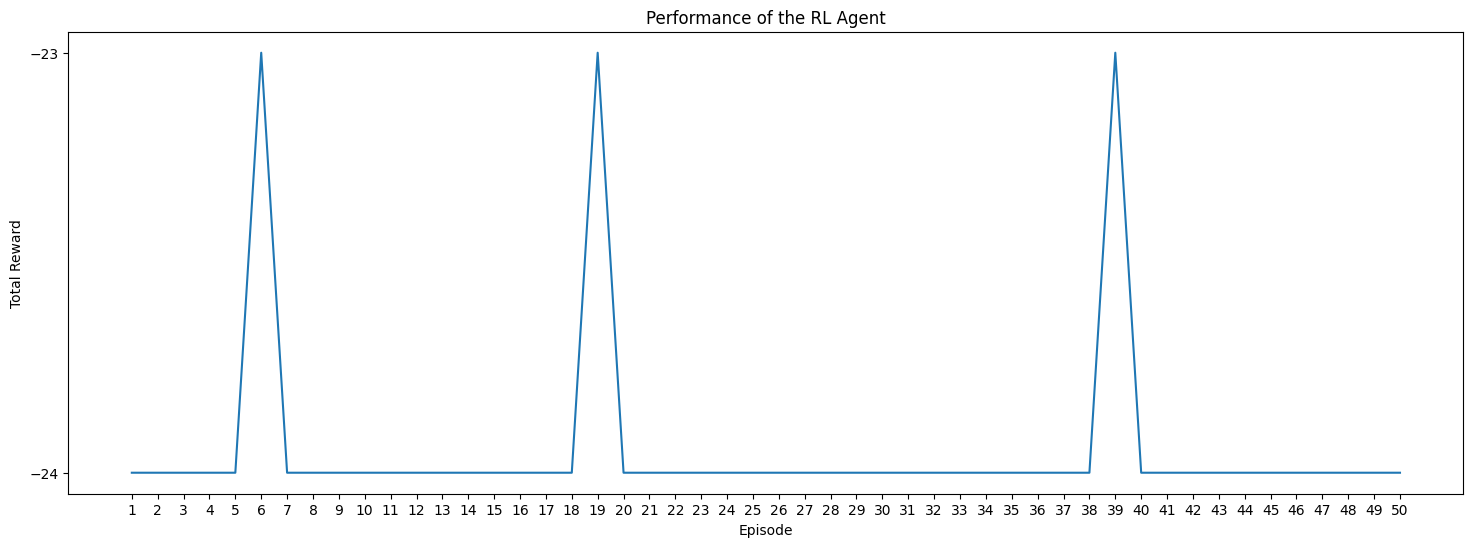

In [18]:
plt.figure(figsize=(18, 6))
plt.plot(range(1, hyperparameters["training_episodes"] + 1), performance_record)
plt.xlabel('Episode')
plt.xticks(range(1, hyperparameters["training_episodes"] + 1, 1))
plt.ylabel('Total Reward')
plt.yticks(range(int(min(performance_record)), int(max(performance_record)) + 1, 1))
plt.title('Performance of the RL Agent')
plt.show()

In [24]:
# Load the saved model
saved_model_path = "models/best_model.keras"  
loaded_model = load_model(saved_model_path)

# Create a new agent with the loaded model
testing_agent = build_agent(loaded_model,actions,hyperparameters)

env = gym.make('ALE/Tennis-v5',full_action_space=True, render_mode="human")
env.reset() 

# Testing loop
for episode in range(hyperparameters["testing_episodes"]):
    state_tuple = env.reset()
    observation = state_tuple[0]  # Extract the observation from the tuple
    state = np.expand_dims(observation, axis=0)  # Add batch dimension
    total_reward = 0
    done = False
    while not done:
        env.render()
        action = testing_agent.act(state)
        observations = env.step(action)
        next_state = observations[0]
        reward = observations[1]
        done = observations[2]
        next_state = np.expand_dims(next_state, axis=0)  # Add batch dimension
        state = next_state
        total_reward += reward
    print(f"Episode: {episode + 1}, Total Reward: {total_reward}")
    
env.close()

d:\Projects\RL-tennis\venv\Lib\site-packages\gymnasium\utils\passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


Episode: 1, Total Reward: -24.0


: 

In [ ]:
# Randomized Algorithm (Low Performance) -- For Comparison Purposes

# env = gym.make('ALE/Tennis-v5',full_action_space=True,render_mode='human')
# env.reset() 
# def random_agent(hyperparameters):
#     episodes = hyperparameters["training_episodes"]

#     for episode in range(1, episodes+1):
#         state = env.reset()
#         done = False
#         score = 0 

#         while not done:
#             env.render()
#             action = env.action_space.sample()
#             observations = env.step(action)
#             next_state = observations[0]
#             reward = observations[1]
#             done = observations[2]
#             score+=reward
#         print('Episode:{} Score:{}'.format(episode, score))
#     env.close()

# random_agent(hyperparameters)